In [1]:
nir_image_path = "D:/Jintu/Jintu_ShareFolder/TestDL_2/Landsat Images/Bands/Landsat_Landsat_2022_01_NIR.tif.tif"

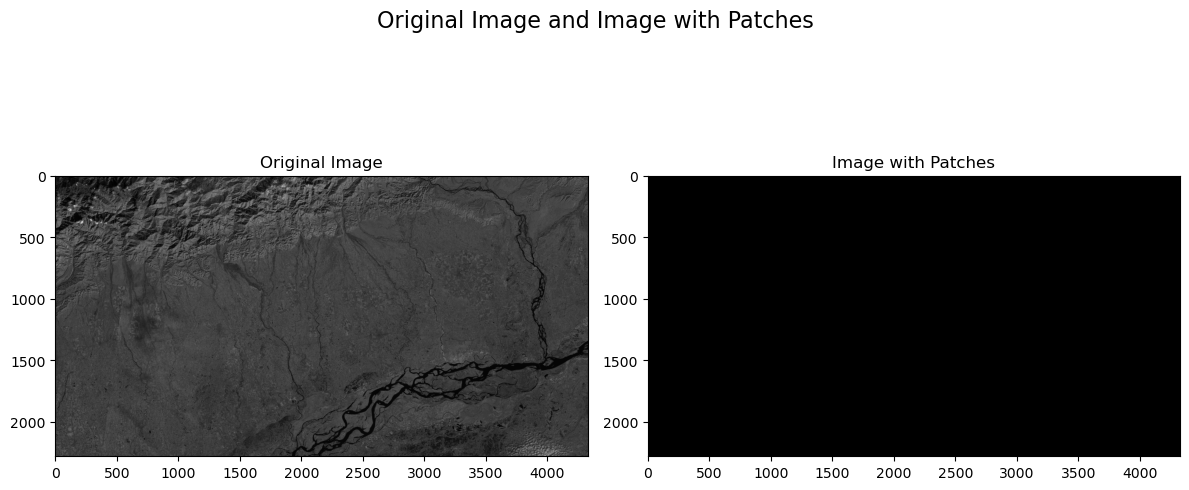

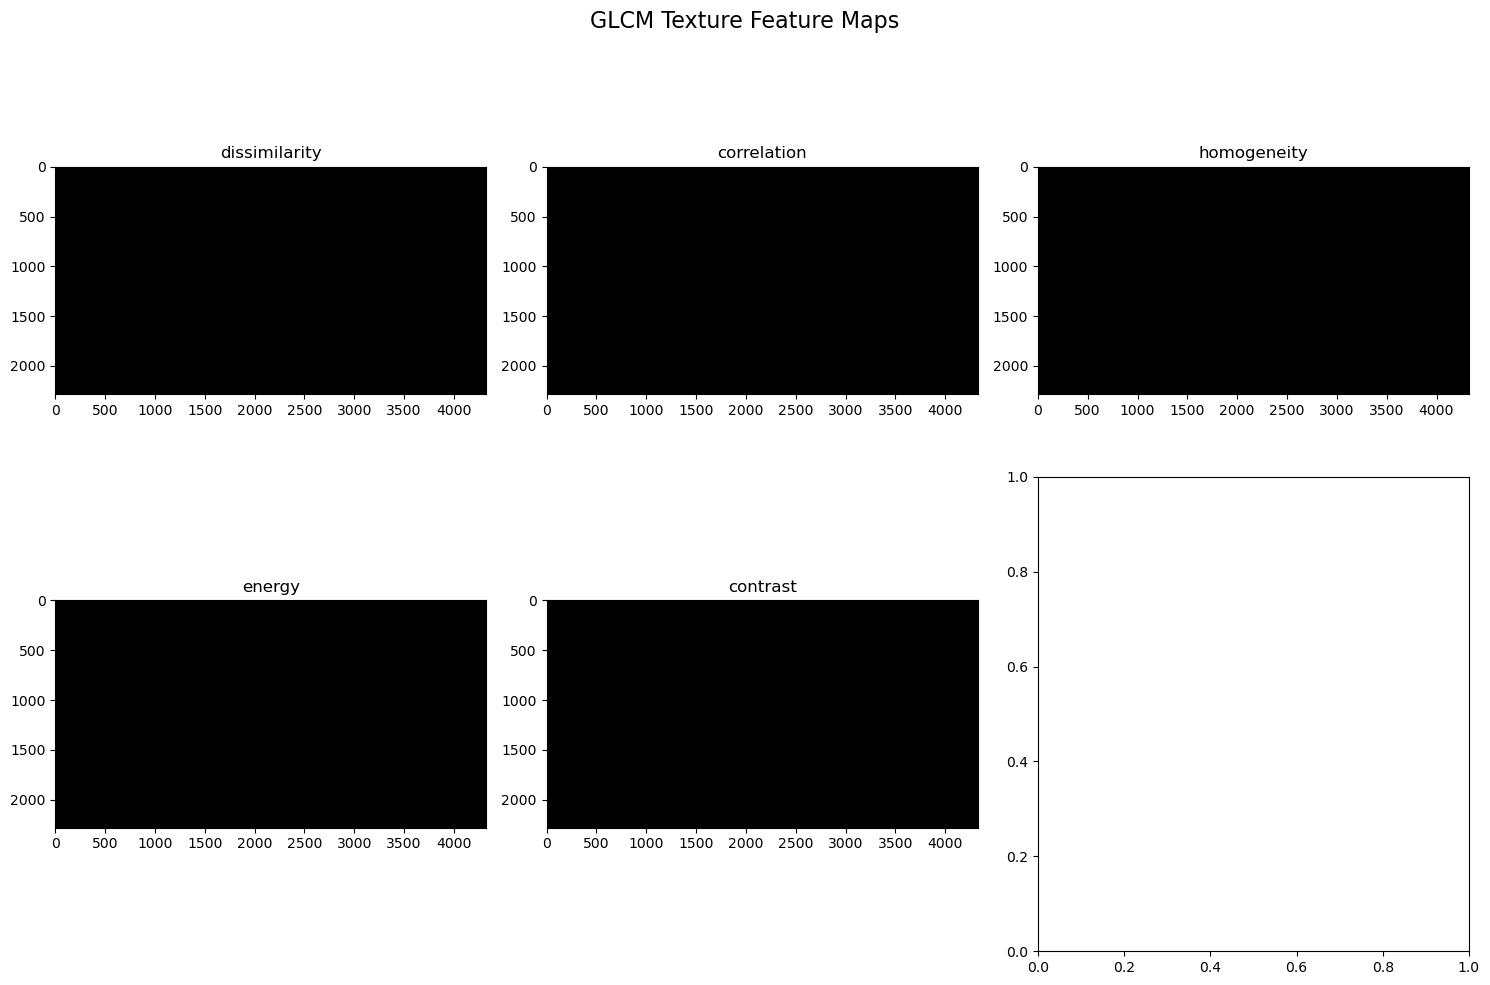

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.feature import graycomatrix, graycoprops
from skimage import img_as_ubyte

# Load the image using rasterio
with rasterio.open(nir_image_path) as src:
    image = src.read(1)  # Assuming a single-band image
    
    image = img_as_ubyte(image)

PATCH_SIZE = 5

# Compute some GLCM properties for the entire image
GLCM = graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
energy = graycoprops(GLCM, 'energy')[0, 0]

# Extract patches from the entire image
image_height, image_width = image.shape
patch_locations = []

for y in range(0, image_height, PATCH_SIZE):
    for x in range(0, image_width, PATCH_SIZE):
        if y + PATCH_SIZE <= image_height and x + PATCH_SIZE <= image_width:
            patch = image[y:y + PATCH_SIZE, x:x + PATCH_SIZE]
            patch_locations.append(patch)

# Create a blank image with the same shape as the original image
blank_image = np.zeros_like(image)

# Place the patches onto the blank image and calculate GLCM properties
diss_sim = np.zeros_like(image, dtype=np.float64)
corr = np.zeros_like(image, dtype=np.float64)
homogen = np.zeros_like(image, dtype=np.float64)
energy_patch = np.zeros_like(image, dtype=np.float64)
contrast = np.zeros_like(image, dtype=np.float64)

for patch in patch_locations:
    # Calculate GLCM properties for each patch
    glcm = graycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    diss_sim += graycoprops(glcm, 'dissimilarity')[0, 0]
    corr += graycoprops(glcm, 'correlation')[0, 0]
    homogen += graycoprops(glcm, 'homogeneity')[0, 0]
    energy_patch += graycoprops(glcm, 'energy')[0, 0]
    contrast += graycoprops(glcm, 'contrast')[0, 0]

# Create subplots for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Original Image and Image with Patches", fontsize=16)

# Display the original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")

# Display the image with patches
axes[1].imshow(blank_image, cmap='gray')
axes[1].set_title("Image with Patches")

plt.tight_layout()
plt.show()

# Create subplots for GLCM texture feature maps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("GLCM Texture Feature Maps", fontsize=16)

# Display and plot the GLCM texture feature maps
properties = ['dissimilarity', 'correlation', 'homogeneity', 'energy', 'contrast']
property_images = [diss_sim, corr, homogen, energy_patch, contrast]

for i, (prop, prop_image) in enumerate(zip(properties, property_images)):
    ax = axes[i // 3, i % 3]
    ax.imshow(prop_image, cmap='gray')
    ax.set_title(prop)

plt.tight_layout()
plt.show()
